# 税率一定の資産のランダム分配の帰結

* Author: 黒木 玄
* Date: 2019-03-20

統計力学の教科書を見ると, 人口が多いとき, 資産を定額徴収してランダムに分配し続けると, 資産分布は指数分布に収束するという事実が解説されている.

それでは, 資産を**定額**徴収(**税額**一定)するのではなく, **定率**徴収(**税率**一定)してランダム分配し続けるとどうなるだろうか?

下の方のシミュレーションの結果を見れば, 税率一定のランダム分配を続けると, 資産分布はガンマ分布に収束し, 税率が**低い**ほど, 収束先の資産分布は**平等**に近付くことがわかる. この計算結果を初めて知ると直観に反する感じがして驚く.

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#シミュレーションとプロットのコード" data-toc-modified-id="シミュレーションとプロットのコード-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>シミュレーションとプロットのコード</a></span><ul class="toc-item"><li><span><a href="#シミュレーションのコード" data-toc-modified-id="シミュレーションのコード-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>シミュレーションのコード</a></span></li><li><span><a href="#プロット用のコード" data-toc-modified-id="プロット用のコード-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>プロット用のコード</a></span></li></ul></li><li><span><a href="#税率一定の場合のシミュレーションの実行" data-toc-modified-id="税率一定の場合のシミュレーションの実行-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>税率一定の場合のシミュレーションの実行</a></span><ul class="toc-item"><li><span><a href="#資産税率90%" data-toc-modified-id="資産税率90%-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>資産税率90%</a></span></li><li><span><a href="#資産税率50%" data-toc-modified-id="資産税率50%-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>資産税率50%</a></span></li><li><span><a href="#資産税率20%" data-toc-modified-id="資産税率20%-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>資産税率20%</a></span></li><li><span><a href="#資産税率5%" data-toc-modified-id="資産税率5%-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>資産税率5%</a></span></li><li><span><a href="#資産税率1%" data-toc-modified-id="資産税率1%-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>資産税率1%</a></span></li></ul></li><li><span><a href="#税額一定の場合のシミュレーションの実行" data-toc-modified-id="税額一定の場合のシミュレーションの実行-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>税額一定の場合のシミュレーションの実行</a></span></li></ul></div>

## シミュレーションとプロットのコード

In [1]:
using Random: seed!

using Base64
dispimg(mime, file) = open(file) do f
    base64 = base64encode(f)
    display("text/html", """<img src="data:$mime;base64,$base64">""")
end

dispimg (generic function with 1 method)

### シミュレーションのコード

In [2]:
using Distributions

function asset_update!(asset, taxfunc, niters)
    n = lastindex(asset)
    ur = UnitRange{Int32}(1:n)
    for iter in 1:niters
        k = rand(ur)
        l = rand(ur)
        d = taxfunc(asset[k])
        asset[k] -= d
        asset[l] += d
    end
end

function sim!(asset, taxfunc; niters=5*10^5, nframes=100, thin=niters÷nframes)
    n = lastindex(asset)
    T = eltype(asset)
    niters = thin * nframes
    Asset = zeros(T, n, nframes+1)
    Asset[:,1] .= asset
    for t in 1:nframes
        asset_update!(asset, taxfunc, thin)
        Asset[:,t+1] .= asset
    end
    Asset
end

function Elog(Asset)
    n, L = size(Asset)
    ElogA = Array{eltype(Asset),1}(undef, L)
    for l in 1:L
        ElogA[l] = mean(log(Asset[k,l]) for k in 1:n)
    end
    ElogA
end

struct ConstantRateTax{T<:AbstractFloat}; rate::T; end
ConstantRateTax(; rate = 0.2) = ConstantRateTax(rate)
(f::ConstantRateTax)(x) = f.rate * x

### プロット用のコード

In [3]:
using Plots
gr()
ENV["PLOTS_TEST"] = "true"

Plots.reset_defaults()
gr(
    legend=false,
    titlefont=font("sans-serif", 12),
    legendfont=font("sans-serif", 8),
    guidefont=font("sans-serif", 10),
    tickfont=font("sans-serif", 8),
    markerstrokewidth=0,
)

function plot_Asset(t, Asset, ElogA; xmax=4.0, ymax=2.0, plottitle="")
    n, L = size(Asset)
    fitdist = fit(Gamma, @view(Asset[:,t+1]))
    x = range(0, xmax, length=201)

    p1 = histogram(@view(Asset[:,t+1]), normed=true, alpha=0.5, linealpha=0, label="asset dist")
    plot!(p1, xlim=(0,xmax), ylim=(0,ymax))
    plot!(p1, x, pdf.(fitdist, x), label="Gamma dist", legend=true)
    if plottitle == ""
        title!(p1, "t = $t")
    else
        title!(p1, "$plottitle (t = $t)")
    end

    ElogAmin, ElogAmax = extrema(ElogA)
    ElogAmargin = 0.05*(ElogAmax - ElogAmin)
    ElogAmin -= ElogAmargin
    ElogAmax += ElogAmargin
    p2 = plot(0:t, ElogA[1:t+1])
    plot!(p2, [L], [0], xlim=(0,L-1), ylim=(ElogAmin, ElogAmax))
    title!(p2, "mean of log(assets)")

    plot(p1, p2, size=(700, 250))
end

function makegif(giffile, Asset; xmax=4.0, ymax=2.0, plottitle="")
    N = size(Asset)[2]-1
    ElogA = Elog(Asset)
    
    # t = 0～L について1フレーム分の画像を作成
    update(t) = plot_Asset(t, Asset, ElogA; xmax=xmax, ymax=ymax, plottitle=plottitle)
    
    # t の動かす範囲の指定
    frames = [0;0;0;0;0;0;0;0;0:N;N;N;N;N;N;N;N;N;N:-1:0]

    # アニメーションオブジェクトの作成
    myanim = Animation()

    # アニメーションのすべてのフレームを作成
    for t in frames
        update(t)
        frame(myanim)
    end
    
    # GIFファイルの作成
    gif(myanim, giffile, fps=10)
end

makegif (generic function with 1 method)

## 税率一定の場合のシミュレーションの実行

### 資産税率90%

  0.387606 seconds (707.62 k allocations: 55.665 MiB, 8.53% gc time)



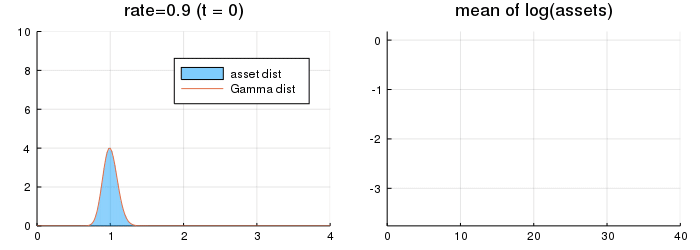

 32.548658 seconds (96.35 M allocations: 3.813 GiB, 6.57% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\genkuroki\OneDrive\msfd28\images\asset_dist_rate0.9.gif
└ @ Plots C:\Users\genkuroki\.julia\packages\Plots\QYETN\src\animation.jl:90


In [4]:
seed!(2018)
n = 2^16
asset = rand(Gamma(100, 0.01), n)
rate = 0.9
taxfunc = ConstantRateTax(rate=rate)
@time Asset = sim!(asset, taxfunc, niters=10^6, nframes=40)

giffile = "images/asset_dist_rate$rate.gif"
@time makegif(giffile, Asset; ymax=10.0, plottitle="rate=$rate")
dispimg("image/gif", giffile)

### 資産税率50%

  0.072987 seconds (57 allocations: 20.502 MiB, 23.77% gc time)



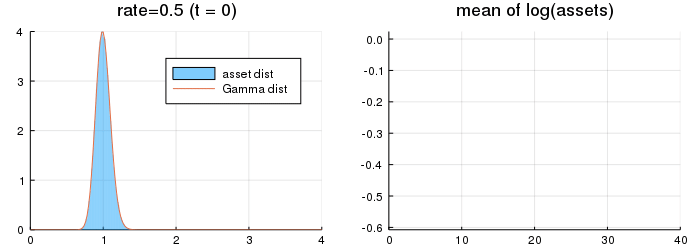

  6.145228 seconds (40.12 M allocations: 1.197 GiB, 4.92% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\genkuroki\OneDrive\msfd28\images\asset_dist_rate0.5.gif
└ @ Plots C:\Users\genkuroki\.julia\packages\Plots\QYETN\src\animation.jl:90


In [5]:
seed!(2018)
n = 2^16
asset = rand(Gamma(100, 0.01), n)
rate = 0.5
taxfunc = ConstantRateTax(rate=rate)
@time Asset = sim!(asset, taxfunc, niters=10^6, nframes=40)

giffile = "images/asset_dist_rate$rate.gif"
@time makegif(giffile, Asset; ymax=4.0, plottitle="rate=$rate")
dispimg("image/gif", giffile)

### 資産税率20%

  0.071026 seconds (1.98 k allocations: 20.615 MiB, 3.37% gc time)



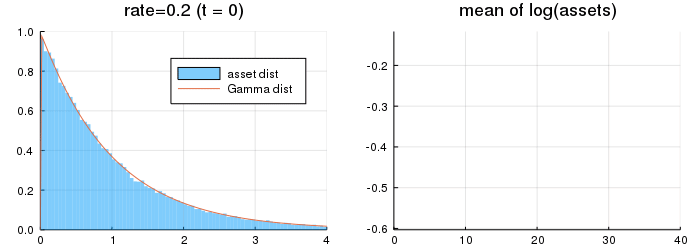

  6.539030 seconds (43.79 M allocations: 1.280 GiB, 3.02% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\genkuroki\OneDrive\msfd28\images\asset_dist_rate0.2.gif
└ @ Plots C:\Users\genkuroki\.julia\packages\Plots\QYETN\src\animation.jl:90


In [6]:
seed!(2018)
n = 2^16
asset = rand(Exponential(1.0), n)
rate = 0.2
taxfunc = ConstantRateTax(rate=rate)
@time Asset = sim!(asset, taxfunc, niters=15*10^5, nframes=40)

giffile = "images/asset_dist_rate$rate.gif"
@time makegif(giffile, Asset; ymax=1.0, plottitle="rate=$rate")
dispimg("image/gif", giffile)

### 資産税率5%

  0.128894 seconds (58 allocations: 20.502 MiB, 2.74% gc time)



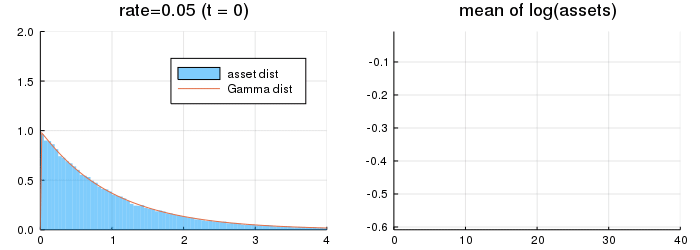

  6.204482 seconds (42.38 M allocations: 1.249 GiB, 4.68% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\genkuroki\OneDrive\msfd28\images\asset_dist_rate0.05.gif
└ @ Plots C:\Users\genkuroki\.julia\packages\Plots\QYETN\src\animation.jl:90


In [7]:
seed!(2018)
n = 2^16
asset = rand(Exponential(1.0), n)
rate = 0.05
taxfunc = ConstantRateTax(rate=rate)
@time Asset = sim!(asset, taxfunc, niters=4*10^6, nframes=40)

giffile = "images/asset_dist_rate$rate.gif"
@time makegif(giffile, Asset; ymax=2.0, plottitle="rate=$rate")
dispimg("image/gif", giffile)

### 資産税率1%

  0.479512 seconds (1.98 k allocations: 20.615 MiB, 1.00% gc time)



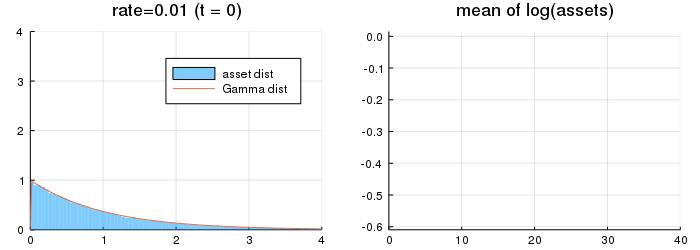

  6.454085 seconds (40.10 M allocations: 1.196 GiB, 3.01% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\genkuroki\OneDrive\msfd28\images\asset_dist_rate0.01.gif
└ @ Plots C:\Users\genkuroki\.julia\packages\Plots\QYETN\src\animation.jl:90


In [8]:
seed!(2018)
n = 2^16
asset = rand(Exponential(1.0), n)
rate = 0.01
taxfunc = ConstantRateTax(rate=rate)
@time Asset = sim!(asset, taxfunc, niters=2*10^7, nframes=40)

giffile = "images/asset_dist_rate$rate.gif"
@time makegif(giffile, Asset; ymax=4.0, plottitle="rate=$rate")
dispimg("image/gif", giffile)

## 税額一定の場合のシミュレーションの実行

税額が一定だと分布の収束先は指数分布になる.

こちらについては統計力学の教科書などによく書かれている.

In [9]:
struct ConstantTax{T<:AbstractFloat}; tax::T; end
ConstantTax(; tax = 0.05) = ConstantTax(tax)
(f::ConstantTax)(x) = ifelse(f.tax ≥ x, zero(x), f.tax)

  2.682780 seconds (254.28 k allocations: 32.727 MiB, 0.20% gc time)



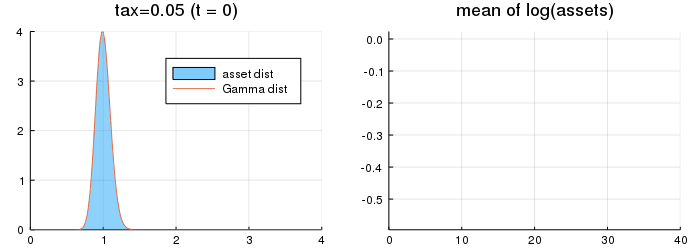

  6.135301 seconds (39.71 M allocations: 1.182 GiB, 4.57% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\genkuroki\OneDrive\msfd28\images\asset_dist_tax0.05.gif
└ @ Plots C:\Users\genkuroki\.julia\packages\Plots\QYETN\src\animation.jl:90


In [10]:
seed!(2018)
n = 2^16
asset = rand(Gamma(100, 0.01), n)
tax = 0.05
taxfunc = ConstantTax(tax=tax)
@time Asset = sim!(asset, taxfunc, niters=10^8, nframes=40)

giffile = "images/asset_dist_tax$tax.gif"
@time makegif(giffile, Asset; ymax=4.0, plottitle="tax=$tax")
dispimg("image/gif", giffile)